# Changing Parameters of the Taxes and Transfers System

This tutorial focuses on the `policy_params` of GETTSIM, one of the two objects returned by the function `set_up_policy_environment`. It is a dictionary that contains all the date-specific parameters (e.g. level of unemployment benefit) that are necessary to compute the target variables we are interested in. GETTSIM not only provides current and past policy environments, but also allows users to alter policies for instance by changing parameters.

In [1]:
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from gettsim import set_up_policy_environment
from gettsim import compute_taxes_and_transfers
from gettsim.synthetic import create_synthetic_data

## Example: Increasing Child Benefit

In this tutorial, we will implement such a policy change: a raise of the child benefit by 20 € for each child.

*Small Recap: Kindergeld is a child benefit that can be claimed by parents in Germany. Mainly lower-income families benefit from Kindergeld. For higher-income families, the tax credits for children are more advantageous, so that they do not receive Kindergeld. The child benefit and how they are implemented in GETTSIM is explained in more detail in the* [advanced usage tutorial](advanced_usage.ipynb).

To implement the raise in GETTSIM, we will change relevant parameters in the existing system by editing the policy parameters that shape the policy environment.

## Finding the Relevant Parameter

Firstly, we can load the existing policy environment for the year 2020 using the function `set_up_policy_environment`.

In [2]:
policy_params, policy_functions = set_up_policy_environment("2020")

We can open the dictionary with all the parameters by typing `policy_params`. The parameters are saved to a nested dictionary, meaning that the dictionary consists of multiple further dictionaries. This can make displaying the parameter values look confusing at first sight.

To get an idea of the structure of the dictionary, we will work us through it step by step. First we take a look at the `keys` of the `dict`. The first layer of keys represent different policy groups.

In [3]:
print(*policy_params.keys(), sep="\n")

eink_st
eink_st_abzuege
soli_st
arbeitsl_geld
soz_vers_beitr
unterhalt
abgelt_st
wohngeld
kinderzuschl
kindergeld
elterngeld
ges_rente
arbeitsl_geld_2
grunds_im_alter


Since we are interested in altering child benefits, we will select the key "kindergeld" to inspect the according parameters further. The parameters are saved to a sub-dictionary which can be selected using `policy_params["kindergeld"]`. It contains the keys to different parameter groups that affect child benefits in the German system:

In [4]:
print(*policy_params["kindergeld"].keys(), sep="\n")

altersgrenze
kindergeld
einkommensgrenze
stundengrenze
kinderbonus
datum


- **kindergeld_altersgrenze** is the maximum age of a child that is entitled to *Kindergeld*.

- **kindergeld** is the amount of money that parents receive for their children.

- **kindergeld_einkommensgrenze** is the maximum annual income of a child that is still entitled to *Kindergeld*.

- **kindergeld_stundengrenze** is the maximum number of weekly working hours of a child that is entitled to *Kindergeld*.

- **datum** specifies the date to which the parameters apply in the German taxes and transfers system. 

The reform we are simulating influences the amount of money that parents receive for their children. Let us take a look at the value of this parameter:

In [5]:
policy_params["kindergeld"]["kindergeld"]

{1: 204, 2: 204, 3: 210, 4: 235}

For the first and second child, the monthly *Kindergeld* is 204€. For the third child, monthly *Kindergeld* is 210€. For each additional child, *Kindergeld* is 235€.

## Changing the Parameter

To implement the bonus, we create a new parameter dictionary by creating a copy of the original which we can then alter.

In [6]:
policy_params_new = copy.deepcopy(policy_params)

Using a loop, we add the 100€ to each entry of our new `policy_params_with_bonus["kindergeld"]["kindergeld"]`.

In [7]:
# Loop through policy paramaters to add the special child bonus.
for n in policy_params_new["kindergeld"]["kindergeld"]:
    policy_params_new["kindergeld"]["kindergeld"][n] += 20

Now we can check if the ```["kindergeld"]["kindergeld"]``` entries in the new parameter dictionary (```policy_params_new```) are as expected:

In [8]:
policy_params_new["kindergeld"]["kindergeld"]

{1: 224, 2: 224, 3: 230, 4: 255}

It worked, we raised all values by 20!

## Applying the Edited Parameter Dictionary to Simulated Households

We use simulated data to illustrate the impact of the bonus we added to the *Kindergeld* parameters. For simplicity, we will only look at households with two children and two parents. 

In [9]:
data = create_synthetic_data(
    hh_typen=["couple"],
    n_children=[2],
    age_adults=[50, 50],
    age_children=[10, 5],
    heterogeneous_vars={"bruttolohn_m": np.arange(1500, 12000, 250)},
)

# Compute number of children in household and add it to data.
children = compute_taxes_and_transfers(
    data=data,
    params=policy_params,
    targets="anz_kinder_bis_17_hh",
    functions=policy_functions,
)
# Compute sum of pension contributions in household and add it to data.
sum_ges_rente_priv_rente_m = compute_taxes_and_transfers(
    data=data,
    params=policy_params,
    targets="sum_ges_rente_priv_rente_m",
    functions=policy_functions,
)
data["anz_kinder_bis_17_hh"] = children["anz_kinder_bis_17_hh"]
data["sum_ges_rente_priv_rente_m"] = sum_ges_rente_priv_rente_m[
    "sum_ges_rente_priv_rente_m"
]
data.head()

,p_id,hh_id,tu_id,hh_typ,kind,bruttolohn_m,alter,rentner,alleinerz,wohnort_ost,...,immobilie_baujahr,vermögen_bedürft_hh,entgeltp,grundr_bew_zeiten,grundr_entgeltp,grundr_zeiten,priv_rente_m,schwerbeh_g,anz_kinder_bis_17_hh,sum_ges_rente_priv_rente_m
0,0,0,0,couple_2_children,False,1500,50,False,False,False,...,1980,0,30.0,360,30.0,360,0.0,False,2,0.0
1,1,0,0,couple_2_children,False,0,50,False,False,False,...,1980,0,30.0,360,30.0,360,0.0,False,2,0.0
2,2,0,0,couple_2_children,True,0,10,False,False,False,...,1980,0,0.0,0,0.0,0,0.0,False,2,0.0
3,3,0,0,couple_2_children,True,0,5,False,False,False,...,1980,0,0.0,0,0.0,0,0.0,False,2,0.0
4,4,1,1,couple_2_children,False,1750,50,False,False,False,...,1980,0,30.0,360,30.0,360,0.0,False,2,0.0


This simulated data set shows 168 households with each two  50 year old parents and their 5 & 10 year old children. The households/tax units only vary in their income.

First, we compute the *Kindergeld* with the original parameters:

In [10]:
kindergeld_status_quo = compute_taxes_and_transfers(
    data=data,
    params=policy_params,
    functions=policy_functions,
    targets=["anz_erwachsene_tu", "zu_verst_eink_mit_kinderfreib_tu"],
    columns_overriding_functions=["anz_kinder_bis_17_hh", "sum_ges_rente_priv_rente_m"],
)

kindergeld_status_quo

,anz_erwachsene_tu,zu_verst_eink_mit_kinderfreib_tu
0,2,-1810.18
1,2,-1810.18
2,2,-1810.18
3,2,-1810.18
4,2,913.60
...,...,...
163,2,113315.68
164,2,116315.68
165,2,116315.68
166,2,116315.68


In [11]:
kindergeld_status_quo = compute_taxes_and_transfers(
    data=data,
    params=policy_params,
    functions=policy_functions,
    targets="kindergeld_m_tu",
    columns_overriding_functions=["anz_kinder_bis_17_hh", "sum_ges_rente_priv_rente_m"],
)

kindergeld_status_quo[["kindergeld_m_tu"]]

,kindergeld_m_tu
0,408.0
1,408.0
2,408.0
3,408.0
4,408.0
...,...
163,0.0
164,0.0
165,0.0
166,0.0


Now we do exactly the same, but using the `policy_params_new`.

In [12]:
kindergeld_new = compute_taxes_and_transfers(
    data=data,
    functions=policy_functions,
    params=policy_params_new,
    targets="kindergeld_m_tu",
    columns_overriding_functions=["anz_kinder_bis_17_hh", "sum_ges_rente_priv_rente_m"],
)
kindergeld_new[["kindergeld_m_tu"]]

,kindergeld_m_tu
0,448.0
1,448.0
2,448.0
3,448.0
4,448.0
...,...
163,0.0
164,0.0
165,0.0
166,0.0


## Compare Results

Using the results shown above, we can now easily visualize and compare the amount of *Kindergeld* for different income groups in the two scenarios. Therefore, we reorganize our data. We create a DataFrame with the total monthly income of each tax unit and the *Kindergeld* they receive with the `policy_params_new` and the `policy_params`:

In [13]:
# Group data by tax unit id and sum the gross monthly income.
total_income_m_tu = data.groupby("tu_id")["bruttolohn_m"].sum()
total_income_m_tu.tail(10)

tu_id
32     9500
33     9750
34    10000
35    10250
36    10500
37    10750
38    11000
39    11250
40    11500
41    11750
Name: bruttolohn_m, dtype: int64

In [14]:
# Create DataFrame with relevant columns for plotting.
df = pd.DataFrame()
df["Kindergeld SQ"] = kindergeld_status_quo["kindergeld_m_tu"]
df["Kindergeld after raise"] = kindergeld_new["kindergeld_m_tu"]
df["tu_id"] = data["tu_id"]
df = df.drop_duplicates("tu_id").set_index("tu_id")
df["Income (per tax unit)"] = total_income_m_tu

We can illustrate the effect of the special child bonus of 2020 by plotting the monthly *Kindergeld* against the income on tax unit level.

Text(0, 0.5, '€ per month')

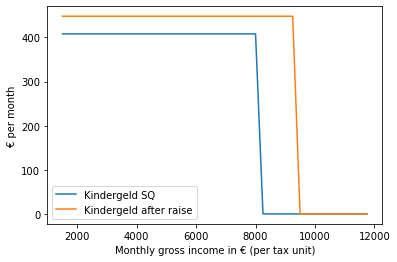

In [15]:
df.plot(x="Income (per tax unit)", y=["Kindergeld SQ", "Kindergeld after raise"])
plt.xlabel("Monthly gross income in € (per tax unit)")
plt.ylabel("€ per month")

Unsurprisingly, the policy reform increases the amount of money that tax units receive if they are entitled to *Kindergeld*. Also, more tax units are entitled to *Kindergeld* as the threshold at which tax credits become more advantageous moves up.

Of course this is a *very* basic visualization and analysis. Have a look at the [policy functions tutorial](policy_functions.ipynb) to see a more sophisticated approach for this example taking into account the interaction with ALG-II. At the same time you will learn learn how to change and add functions to a policy environment!
